In [1]:
import os
import glob

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf

## Load Dataset

In [3]:
dfs = []
for file in glob.glob(os.path.join("../dataset/mlflow", "*.csv")):
    # get file name as algorithm expriment name
    filename = os.path.splitext(os.path.basename(file))[0]

    # read and parse date/time
    df = pd.read_csv(file, parse_dates=["Start Time"]).assign(filename=filename)
    df["Duration"] = pd.to_timedelta(df["Duration"])
        
    # save to list
    dfs.append(df)

# concat all
df = pd.concat(dfs, ignore_index=True)
df.head()

,Start Time,Duration,Run ID,Name,Source Type,Source Name,User,Status,bootstrap,class_weight,max_depth,max_features,min_samples_leaf,min_samples_split,n_estimators,n_jobs,random_state,accuracy,f1,mcc,precision,recall,filename,criterion,max_leaf_nodes,bootstrap_type,colsample_bylevel,depth,grow_policy,iterations,learning_rate,min_data_in_leaf,random_seed,scale_pos_weight,subsample,task_type,verbose
0,2024-06-23 10:00:49,0 days 00:00:44.600000,dab3b8b7c6a242adb55cb340babecb9a,trial-96,LOCAL,autogbifml,fahmi,FINISHED,False,"{0: 1.0, 1: 1}",63.0,sqrt,1.0,2.0,1230.0,12.0,21.0,0.995173,0.995186,0.990366,0.992028,0.998365,thesis_random_forest_tune_v4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2024-06-23 09:44:57,0 days 00:00:44.600000,7eb1b70627194ac6945cec6f7614bbc4,trial-77,LOCAL,autogbifml,fahmi,FINISHED,False,"{0: 1.0, 1: 1}",83.0,sqrt,1.0,2.0,1230.0,12.0,21.0,0.995173,0.995186,0.990366,0.992028,0.998365,thesis_random_forest_tune_v4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2024-06-23 09:54:10,0 days 00:00:43.800000,4d6ec8a865e7433fb06216b1d6766c82,trial-88,LOCAL,autogbifml,fahmi,FINISHED,False,"{0: 1.0, 1: 1}",70.0,sqrt,1.0,2.0,1200.0,12.0,21.0,0.995155,0.995168,0.990330,0.991992,0.998365,thesis_random_forest_tune_v4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2024-06-23 09:51:14,0 days 00:00:43.700000,e8fa4f6f77e84bc4863efe63324d71a9,trial-84,LOCAL,autogbifml,fahmi,FINISHED,False,"{0: 1.0, 1: 1}",67.0,sqrt,1.0,2.0,1200.0,12.0,21.0,0.995155,0.995168,0.990330,0.991992,0.998365,thesis_random_forest_tune_v4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2024-06-23 09:50:28,0 days 00:00:45.100000,c8ed9d50de044322abba92b9cff823d4,trial-83,LOCAL,autogbifml,fahmi,FINISHED,False,"{0: 1.0, 1: 1}",83.0,sqrt,1.0,2.0,1210.0,12.0,21.0,0.995155,0.995167,0.990330,0.991992,0.998365,thesis_random_forest_tune_v4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
df_stats = df[["filename", "Duration", "Name", "mcc", "accuracy", "precision", "recall", "f1"]].copy()
df_stats["algorithm"] = df_stats["filename"].str.replace("thesis_", "") #.replace("_tune.+", "", regex=True)
df_stats["trial"] = df_stats["Name"].str.replace("trial-", "").astype(int)
df_stats = df_stats.drop(columns=["filename", "Name"]).rename(columns={"Duration": "duration"})
df_stats.head()

,duration,mcc,accuracy,precision,recall,f1,algorithm,trial
0,0 days 00:00:44.600000,0.990366,0.995173,0.992028,0.998365,0.995186,random_forest_tune_v4,96
1,0 days 00:00:44.600000,0.990366,0.995173,0.992028,0.998365,0.995186,random_forest_tune_v4,77
2,0 days 00:00:43.800000,0.990330,0.995155,0.991992,0.998365,0.995168,random_forest_tune_v4,88
3,0 days 00:00:43.700000,0.990330,0.995155,0.991992,0.998365,0.995168,random_forest_tune_v4,84
4,0 days 00:00:45.100000,0.990330,0.995155,0.991992,0.998365,0.995167,random_forest_tune_v4,83


In [5]:
df_stats.pivot_table(index=["algorithm"], values=["duration", "mcc", "precision", "recall", "f1"], aggfunc=["mean", "sum"])

mean            ...        sum           
                                    duration        f1  ...  precision     recall
algorithm                                               ...                      
catboost_tune_v3      0 days 00:03:38.204000  0.963110  ...  94.259660  98.507112
catboost_tune_v4      0 days 00:05:52.001000  0.973083  ...  95.910635  98.814524
decision_tree_tune_v3 0 days 00:00:04.765000  0.899330  ...  84.903707  95.659771
decision_tree_tune_v4 0 days 00:00:06.229000  0.907049  ...  85.625950  96.485147
random_forest_tune_v3 0 days 00:00:39.124000  0.978911  ...  96.614664  99.213509
random_forest_tune_v4 0 days 00:00:51.954000  0.991439  ...  98.629622  99.673300
xgboost_tune_v3       0 days 00:00:50.355000  0.981415  ...  96.721499  99.607665
xgboost_tune_v4       0 days 00:00:46.081000  0.992562  ...  98.622939  99.901632

[8 rows x 10 columns]

In [6]:
max_idx = df_stats.groupby("algorithm")["mcc"].idxmax()
df_stats.loc[max_idx, :].sort_values(by="mcc", ascending=False).round(4).style.background_gradient(cmap="Blues", subset="mcc")

,duration,mcc,accuracy,precision,recall,f1,algorithm,trial
223,0 days 00:08:36,0.990800,0.995400,0.991300,0.999500,0.995400,catboost_tune_v4,76
500,0 days 00:00:41.900000,0.990500,0.995200,0.991100,0.999400,0.995200,xgboost_tune_v4,93
0,0 days 00:00:44.600000,0.990400,0.995200,0.992000,0.998400,0.995200,random_forest_tune_v4,96
700,0 days 00:08:48,0.973400,0.986600,0.975900,0.997900,0.986700,catboost_tune_v3,99
600,0 days 00:00:43.100000,0.970800,0.985300,0.974200,0.996900,0.985400,xgboost_tune_v3,94
400,0 days 00:00:47.400000,0.967900,0.983800,0.973100,0.995200,0.984000,random_forest_tune_v3,80
300,0 days 00:00:06.500000,0.834900,0.914300,0.869100,0.975500,0.919200,decision_tree_tune_v4,98
100,0 days 00:00:04.800000,0.825500,0.910200,0.869300,0.965700,0.914900,decision_tree_tune_v3,51


(0.0, 1.0)

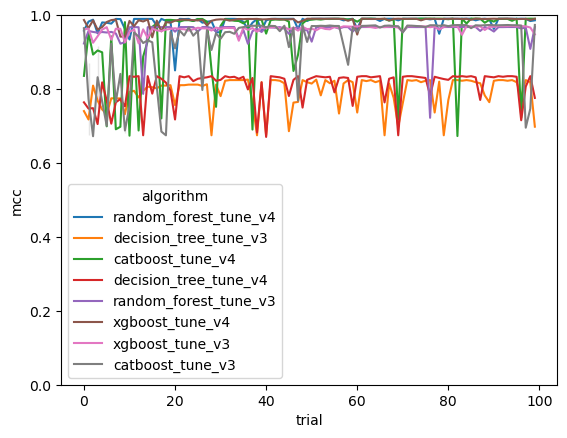

In [7]:
sns.lineplot(data=df_stats, x="trial", y="mcc", hue="algorithm")
plt.ylim(0, 1)

<Axes: xlabel='algorithm', ylabel='mcc'>

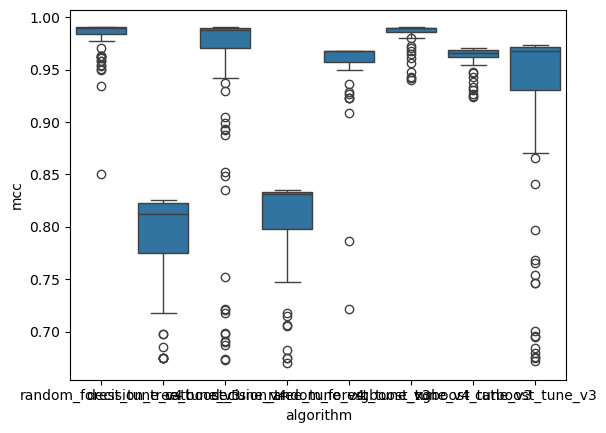

In [8]:
sns.boxplot(data=df_stats, x="algorithm", y="mcc")

## ANOVA

In [11]:
df_anova = df_stats[df_stats["algorithm"].isin(["random_forest_tune_v4", "catboost_tune_v4", "xgboost_tune_v4"])].copy()
df_anova

,duration,mcc,accuracy,precision,recall,f1,algorithm,trial
0,0 days 00:00:44.600000,0.990366,0.995173,0.992028,0.998365,0.995186,random_forest_tune_v4,96
1,0 days 00:00:44.600000,0.990366,0.995173,0.992028,0.998365,0.995186,random_forest_tune_v4,77
2,0 days 00:00:43.800000,0.990330,0.995155,0.991992,0.998365,0.995168,random_forest_tune_v4,88
3,0 days 00:00:43.700000,0.990330,0.995155,0.991992,0.998365,0.995168,random_forest_tune_v4,84
4,0 days 00:00:45.100000,0.990330,0.995155,0.991992,0.998365,0.995167,random_forest_tune_v4,83
...,...,...,...,...,...,...,...,...
595,0 days 00:00:15.700000,0.955964,0.977624,0.959816,0.996987,0.978046,xgboost_tune_v4,17
596,0 days 00:01:00,0.947383,0.973196,0.952501,0.996085,0.973802,xgboost_tune_v4,60
597,0 days 00:01:12,0.942482,0.970637,0.947953,0.995979,0.971369,xgboost_tune_v4,9
598,0 days 00:00:43.500000,0.941705,0.970238,0.947391,0.995797,0.970987,xgboost_tune_v4,8


In [19]:
model = smf.ols("mcc ~ C(algorithm)", data=df_anova).fit()
anova_table = sm.stats.anova_lm(model, typ=3)
anova_table

,sum_sq,df,F,PR(>F)
Intercept,89.232851,1.0,30349.141327,4.413907e-301
C(algorithm),0.103422,2.0,17.587488,6.044303e-08
Residual,0.873242,297.0,NaN,NaN


In [20]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    mcc   R-squared:                       0.106
Model:                            OLS   Adj. R-squared:                  0.100
Method:                 Least Squares   F-statistic:                     17.59
Date:                Wed, 26 Jun 2024   Prob (F-statistic):           6.04e-08
Time:                        10:43:28   Log-Likelihood:                 450.22
No. Observations:                 300   AIC:                            -894.4
Df Residuals:                     297   BIC:                            -883.3
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
=========================================================================================================
                                            coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------
Intercept                                 0.9446      0.005    174.210      0.000       0.934       0.955
C(algorithm)[T.random_forest_tune_v4]     0.0382      0.008      4.982      0.000       0.023       0.053
C(algorithm)[T.xgboost_tune_v4]           0.0405      0.008      5.278      0.000       0.025       0.056
==============================================================================
Omnibus:                      240.968   Durbin-Watson:                   1.710
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2705.912
Skew:                          -3.418   Prob(JB):                         0.00
Kurtosis:                      16.028   Cond. No.                         3.73
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""